In [5]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

import pyeeg
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time

In [16]:
eeg_fs = 250
eeg_chans = ["C3", "Cz", "C4"]
eog_chans = ["EOG:ch01", "EOG:ch02", "EOG:ch03"]
all_chans = eeg_chans + eog_chans
event_types = {0:"left", 1:"right"}

In [17]:
# Multiple bar graph plotting
def plotMultipleBarGraphs(bars, bar_width, bar_names, group_names, error_values=None, title=None, xlabel=None, ylabel=None): 
    if len(bar_names) != len(bars):
        print("group names must be same length as bars")
        return 
    # Set position of bar on X axis
    positions = list()
    positions.append(np.arange(len(bars[0])))
    for i, bar in enumerate(bars): 
        if i>0: 
            positions.append([x + bar_width for x in positions[i-1]])

    # Make the plot
    for i, pos in enumerate(positions):
        plt.bar(pos, bars[i], width=bar_width, label=bar_names[i])
    
    if error_values is not None: 
        for i, pos in enumerate(positions):
            plt.errorbar(pos, bars[i], yerr=error_values[i], fmt='.k')
    
    # Add xticks on the middle of the group bars
    if xlabel: 
        plt.xlabel(xlabel)
    if ylabel: 
        plt.ylabel(ylabel)
    if title: 
        plt.title(title)
    plt.xticks([r + bar_width for r in range(len(bars[0]))], group_names)

    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [18]:
epoch_df_filename = Path("../dataset_neural_analysis/data/epoched_train.pkl")
eeg_epoch_full_df = pd.read_pickle(epoch_df_filename)
eeg_epoch_full_df.head(2)

,patient_id,start_time,event_type,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
0,B0101T,223556.0,0,"[-3.6285954070344086, -2.337682154573892, -3.6...","[-2.920576791027695, -2.47501335164416, -2.548...","[5.502403295948728, 6.485084306095978, 6.68955...","[7.354848554207674, 4.699778744182498, 8.39246...","[5.676356145571068, 10.2235446707866, 16.08300...","[9.857328145265887, 4.303044174868391, 15.5336..."
1,B0101T,232996.0,1,"[2.9480430304417484, -0.05493247882810711, 0.3...","[4.437323567559321, 2.4872205691615163, 0.9674...","[1.3855191882200348, -0.4699778744182498, 0.44...","[-18.127718013275352, 18.188754100862134, -5.8...","[-14.373998626688028, 21.484702830548557, -6.2...","[-11.9325551232166, 20.202944991226055, -9.613..."


In [19]:
# Power Bin extraction
import pyeeg
def getPowerRatio(eeg_data, binning, eeg_fs=250):
    power, power_ratio = pyeeg.bin_power(eeg_data, binning, eeg_fs)
    return np.array(power_ratio)
def getIntervals(binning): 
    intervals = list()
    for i, val in enumerate(binning[:-1]): 
        intervals.append((val, binning[i+1]))
    return intervals

In [53]:
# Create a dataframe with the event_type and the power bin information for each trial

power_ratios = {'y': []}
binning=[0.5, 4, 7, 12, 30]
intervals = getIntervals(binning)
for i in range(0, len(eeg_epoch_full_df)): 
    event_type = eeg_epoch_full_df['event_type'][i]
    for ch in eeg_chans: 
        ratios = getPowerRatio(eeg_epoch_full_df[ch][i][:], binning)
        for j, interval in enumerate(intervals): 
            key = ch + "_" + str(interval)
            if key not in power_ratios: 
                power_ratios[key] = list()
            power_ratios[key].append(ratios[j])
    power_ratios['y'].append(eeg_epoch_full_df['event_type'][i])

power_ratios_df = pd.DataFrame(power_ratios)
power_ratios_df.head()

,y,"C3_(0.5, 4)","C3_(4, 7)","C3_(7, 12)","C3_(12, 30)","Cz_(0.5, 4)","Cz_(4, 7)","Cz_(7, 12)","Cz_(12, 30)","C4_(0.5, 4)","C4_(4, 7)","C4_(7, 12)","C4_(12, 30)"
0,0,0.190380,0.103543,0.240617,0.465460,0.183383,0.098315,0.310271,0.408030,0.176447,0.098352,0.214169,0.511032
1,1,0.338060,0.081168,0.118130,0.462642,0.238569,0.106955,0.228072,0.426404,0.469660,0.102372,0.121269,0.306698
2,0,0.234302,0.101459,0.162443,0.501796,0.191182,0.157964,0.189180,0.461674,0.235221,0.127780,0.156822,0.480177
3,1,0.247263,0.139796,0.177430,0.435511,0.316947,0.093709,0.204395,0.384950,0.289331,0.099774,0.166477,0.444418
4,1,0.249109,0.107688,0.202389,0.440814,0.189605,0.109879,0.284962,0.415554,0.249175,0.093967,0.197290,0.459568


In [56]:
# Calculate the standard error means between epochs for each channel from the power ratios obtained previously

chan_frequency_sems = {}
chan_frequency_avgs = {}

for event_type in event_types: 
    for ch in eeg_chans: 
        for interval in intervals: 
            key = ch + "_" + str(interval)
            if key not in chan_frequency_sems: 
                chan_frequency_sems[key] = list()
                chan_frequency_avgs[key] = list()
            this_data = power_ratios_df[power_ratios_df['y'] == event_type][key]
            sem = np.std(this_data) / np.sqrt(len(this_data)) # Standard Error of Mean calculation
            chan_frequency_sems[key].append(sem)
            chan_frequency_avgs[key].append(np.mean(this_data))
            
std_err_df = pd.DataFrame(chan_frequency_sems)
avg_df = pd.DataFrame(chan_frequency_avgs)

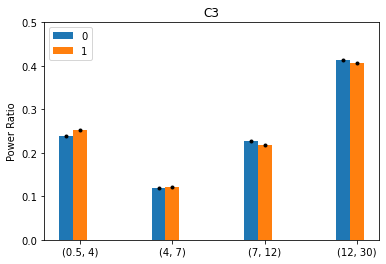

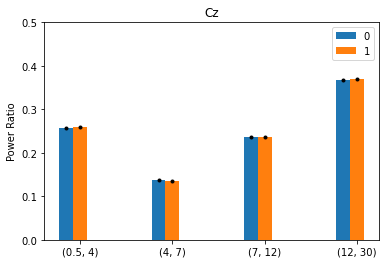

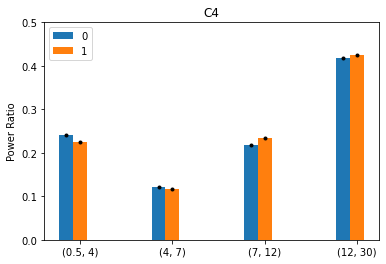

In [78]:
for chan in eeg_chans: 
    chan_of_interest = chan
    event_power_ratios = {}
    event_sems = {}
    power_ratios_for_chan = []
    sem_for_chan = []
    for event_type in event_types: 
        if event_type not in event_power_ratios: 
            event_power_ratios[event_type] = []
            event_sems[event_type] = []
        for interval in intervals: 
            key = chan_of_interest + "_" + str(interval)
            event_power_ratios[event_type].append(avg_df[key][event_type])
            event_sems[event_type].append(std_err_df[key][event_type])

    event_sems_df = pd.DataFrame(event_sems)
    event_power_ratios_df = pd.DataFrame(event_power_ratios)
    
    plt.title(chan_of_interest)
    plt.ylim((0, 0.5))
    plt.ylabel("Power Ratio")
    plotMultipleBarGraphs(np.transpose(np.array(event_power_ratios_df)), 0.15, [0, 1], intervals, error_values=np.transpose(np.array(event_sems_df)))